In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, re, time, warnings, pickle, psutil, random

from math import ceil
import lightgbm as lgb
from typing import Union

warnings.filterwarnings('ignore')

In [2]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

## RMSE metric for occasions 
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [3]:
########################### Vars
#################################################################################
TARGET    = 'sales'    # Our Target     
END_TRAIN = 1913       # Last day of training set     
SEED      = 42         # Seed for deterministic processes  
seed_everything(SEED)  # Seeder

VERBOSE   = False      # Verbosity on all wrmsse levels   

remove_features = ['id','t_block','date','d', 'wm_yr_wk',TARGET]

In [4]:
########################### Metric and Evaluators
########################### get_evaluators(items_ids=None)
########################### items_ids -> list of subset of item_id 

In [5]:
########################### Init Metric
########################### https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834
#################################################################################
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(self.group_ids):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def get_scale(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        return getattr(self, f'lv{lv}_scale')
        
    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')       
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        if VERBOSE:
            print(np.round(all_scores,3))
        return np.mean(all_scores)

    def full_score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        print(np.round(all_scores,3))
        return np.mean(all_scores)
    
class WRMSSEForLightGBM(WRMSSEEvaluator):

    def feval(self, preds, dtrain):
        preds = preds.reshape(self.valid_df[self.valid_target_columns].shape, order='F') #.transpose()
        score = self.score(preds)
        return 'WRMSSE', score, False
    
    def full_feval(self, preds, dtrain):
        preds = preds.reshape(self.valid_df[self.valid_target_columns].shape, order='F') #.transpose()
        score = self.full_score(preds)
        return 'WRMSSE', score, False
    
########################### Lgb evaluators
#################################################################################
def get_evaluators(items_ids):
    prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
    calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
    train_fold_df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
    train_fold_df = train_fold_df[train_fold_df['item_id'].isin(items_ids)].reset_index(drop=True)

    lgb_evaluators = []
    for i in range(2):
        temp_train = train_fold_df.iloc[:,:-28*(i+1)]
        if i==0:
            temp_valid = train_fold_df.iloc[:, -28*(i+1):]
        else:
            temp_valid = train_fold_df.iloc[:, -28*(i+1):-28*i]

        lgb_evaluator = WRMSSEForLightGBM(temp_train, temp_valid, calendar, prices)
        lgb_evaluators.append(lgb_evaluator)

    del train_fold_df, temp_train, temp_valid, prices, calendar
    return lgb_evaluators

In [6]:
########################### Model
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',                      
                    'metric': ['rmse'],           
                    'subsample': 0.5,                
                    'subsample_freq': 1,
                    'learning_rate': 0.05,           
                    'num_leaves': 2**8-1,            
                    'min_data_in_leaf': 2**8-1,     
                    'feature_fraction': 0.8,
                    'n_estimators': 1500,            
                    'early_stopping_rounds': 30,     
                    'seed': SEED,
                    'verbose': -1,
                } 

def make_fast_test(df, block=0, loss_func='tweedie'):
    df = df.copy()
    local_params = lgb_params.copy()           

    # To be sure that some features are categoricals
    icols = ['item_id','dept_id','cat_id','store_id','state_id', 
             'event_name_1','event_type_1','event_name_2','event_type_2',]
    for col in icols:
        try:
            df[col] = df[col].astype('category')
        except:
            pass
    
    # Our features
    features_columns = [col for col in list(df) if col not in remove_features]
    print(features_columns)
    
    train_mask = (df['t_block']<(df['t_block'].max()-block))
    valid_mask = (df['t_block']==(df['t_block'].max()-block))
    
    train_data = lgb.Dataset(df[train_mask][features_columns], label=df[train_mask][TARGET])
    valid_data = lgb.Dataset(df[valid_mask][features_columns], label=df[valid_mask][TARGET])
    
    print('Train time block', df[train_mask]['t_block'].max(), df[train_mask]['d'].min(), df[train_mask]['d'].max())
    print('Valid time block', df[valid_mask]['t_block'].max(), df[valid_mask]['d'].min(), df[valid_mask]['d'].max())
    
    temp_df = df[valid_mask]
    del df
    
    if loss_func=='custom':
        seed_everything(SEED)
        estimator = lgb.train(
                                local_params,
                                train_data,
                                valid_sets = [valid_data],
                                verbose_eval = 20,
                                fobj = custom_loss, 
                                feval=lgb_evaluators[block].feval,
                            )
        
    elif loss_func=='tweedie':
        local_params['objective'] = 'tweedie'             
        local_params['tweedie_variance_power'] = 1.1  
        seed_everything(SEED)
        estimator = lgb.train(
                                local_params,
                                train_data,
                                valid_sets = [valid_data],
                                verbose_eval = 20,
                                feval=lgb_evaluators[block].feval,
                            ) 
        
    else:
        local_params['objective'] = 'regression'             
        seed_everything(SEED)
        estimator = lgb.train(
                                local_params,
                                train_data,
                                valid_sets = [valid_data],
                                verbose_eval = 20,
                                feval=lgb_evaluators[block].feval,
                            )
        
    temp_df['preds'] = estimator.predict(temp_df[features_columns])
    temp_df = temp_df[['id','d',TARGET,'preds']]
    return estimator, temp_df

In [7]:
########################### Make grid
#################################################################################
grid_df = pd.concat([pd.read_pickle('../input/m5-simple-fe/grid_part_1.pkl'),
                     pd.read_pickle('../input/m5-simple-fe/grid_part_3.pkl').iloc[:,2:]],
                     axis=1)
grid_df['t_block'] = grid_df['d'].apply(lambda x: ceil((x+19)/(28))).astype(np.int8)
grid_df = grid_df[grid_df['d']<=END_TRAIN]
grid_df = grid_df[grid_df['t_block']>(grid_df['t_block'].max()-24)].reset_index(drop=True) #last 2 years
lgb_evaluators = get_evaluators(list(grid_df['item_id'].unique()))
gc.collect()

9

In [8]:
########################### Unrealistic lag 1+
#################################################################################
grouper = grid_df.groupby(['id'])[TARGET]
for i in range(1,8):
    print(i)
    grid_df['normal_lag_'+str(i)] = grouper.transform(lambda x: x.shift(i)).astype(np.float32)
    
del grouper

1
2
3
4
5
6
7


['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'release', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'normal_lag_1', 'normal_lag_2', 'normal_lag_3', 'normal_lag_4', 'normal_lag_5', 'normal_lag_6', 'normal_lag_7']
Train time block 68 1242 1885
Valid time block 69 1886 1913
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmse: 2.38929	valid_0's WRMSSE: 1.25496
[40]	valid_0's rmse: 2.01494	valid_0's WRMSSE: 0.805408
[60]	valid_0's rmse: 1.94639	valid_0's WRMSSE: 0.630623
[80]	valid_0's rmse: 1.92803	valid_0's WRMSSE: 0.55153
[100]	valid_0's rmse: 1.92045	valid_0's WRMSSE: 0.520019
[120]	valid_0's rmse: 1.91644	valid_0's WRMSSE: 0.517547
[140]	valid_0's rmse: 1.91264	valid_0's WRMSSE: 0.510774
[160]	valid_0's rmse: 1.91037	valid_0's WRMSSE: 0.506772
[180]	valid_0's rmse: 1.90864	valid_0's WRMSSE: 0.504455
[200]	valid_0's rmse: 1.90698	val

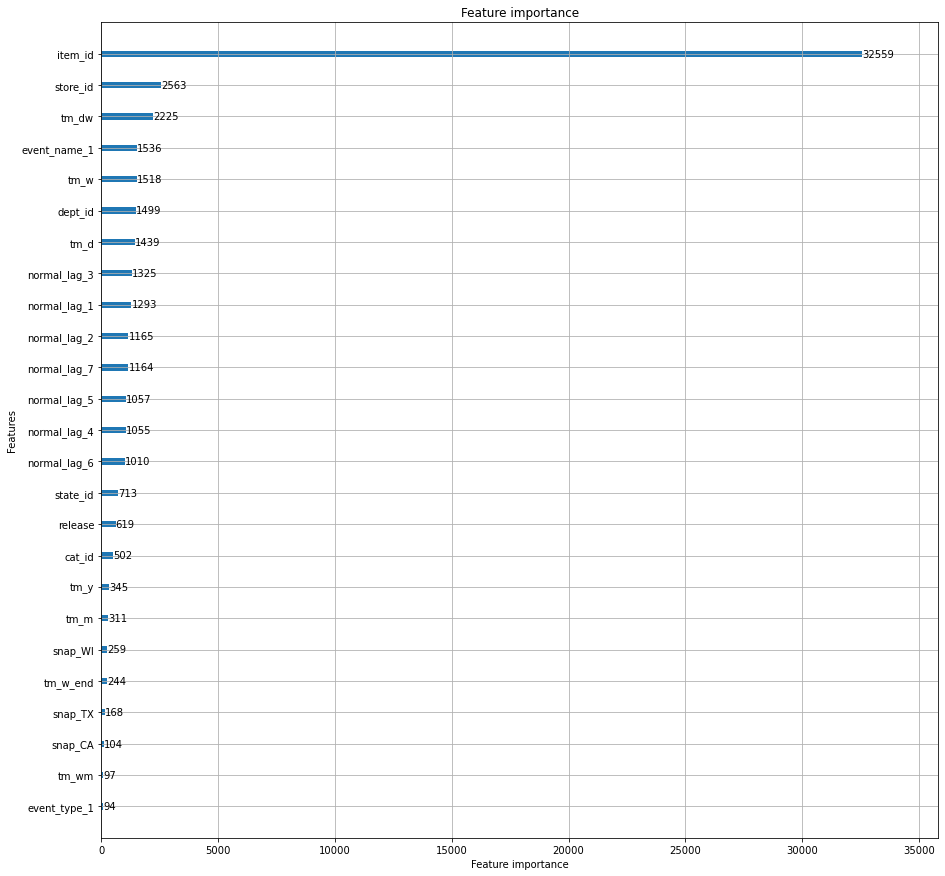

In [9]:
########################### Make simple model with tweedie
#################################################################################
model_tweedie, preds_tweedie_df = make_fast_test(grid_df, 0, 'tweedie')
print(lgb_evaluators[0].full_feval(preds_tweedie_df['preds'].values, pd.DataFrame())) 
lgb.plot_importance(model_tweedie, figsize=(15,15))

In [10]:
########################### Some custom loss here
########################### The place to make own one
#################################################################################
def custom_loss(y_pred, y_true):
    grad = y_pred - y_true.get_label()
    hess = np.ones_like(y_pred)
    return grad, hess

['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'release', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'normal_lag_1', 'normal_lag_2', 'normal_lag_3', 'normal_lag_4', 'normal_lag_5', 'normal_lag_6', 'normal_lag_7']
Train time block 68 1242 1885
Valid time block 69 1886 1913
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmse: 2.31591	valid_0's WRMSSE: 2.10384
[40]	valid_0's rmse: 2.00306	valid_0's WRMSSE: 1.04782
[60]	valid_0's rmse: 1.94207	valid_0's WRMSSE: 0.715297
[80]	valid_0's rmse: 1.92396	valid_0's WRMSSE: 0.597826
[100]	valid_0's rmse: 1.91672	valid_0's WRMSSE: 0.555858
[120]	valid_0's rmse: 1.91308	valid_0's WRMSSE: 0.53617
[140]	valid_0's rmse: 1.91048	valid_0's WRMSSE: 0.528906
[160]	valid_0's rmse: 1.90842	valid_0's WRMSSE: 0.524767
[180]	valid_0's rmse: 1.90722	valid_0's WRMSSE: 0.522682
[200]	valid_0's rmse: 1.90617	vali

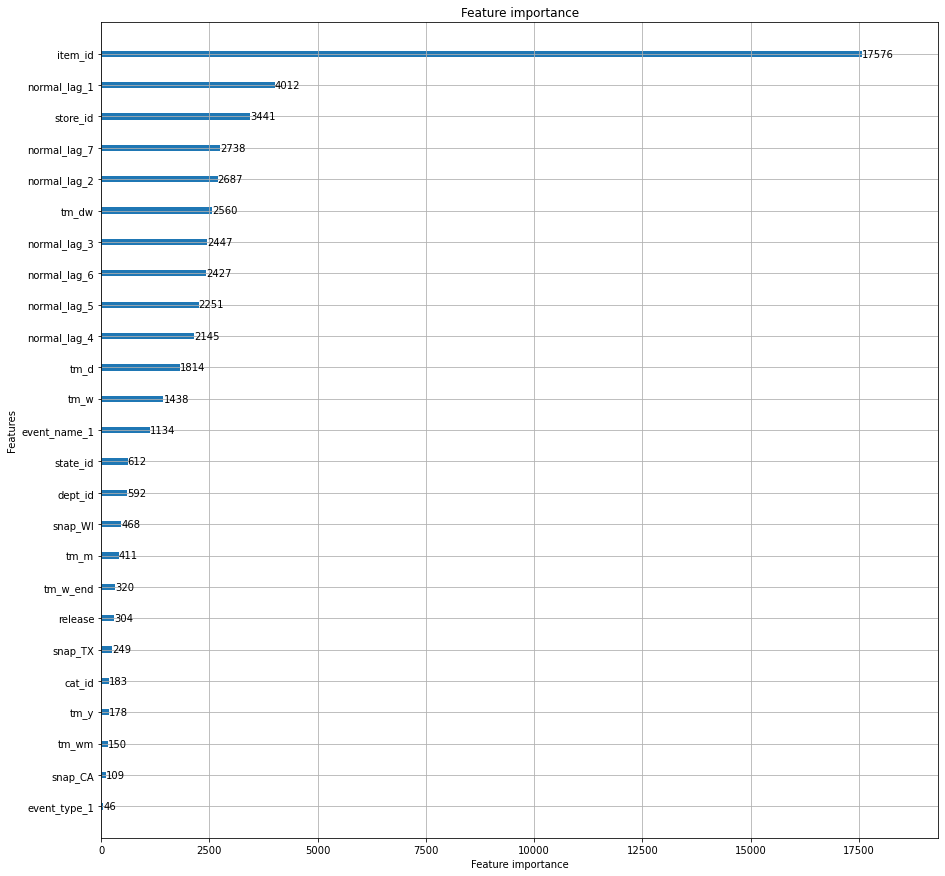

In [11]:
########################### Make simple model with custom loss
#################################################################################
model_custom, preds_custom_df = make_fast_test(grid_df, 0, 'custom')
print(lgb_evaluators[0].full_feval(preds_custom_df['preds'].values, pd.DataFrame())) 
lgb.plot_importance(model_custom, figsize=(15,15))

In [12]:
########################### Lets test several folds
#################################################################################
all_preds = pd.DataFrame()
for i in [0,1]:
    model_tweedie, preds_tweedie_df = make_fast_test(grid_df, i, 'tweedie')
    all_preds = pd.concat([all_preds, preds_tweedie_df]).reset_index(drop=True) 
    print('-'*10)
    
all_preds

['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'release', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'normal_lag_1', 'normal_lag_2', 'normal_lag_3', 'normal_lag_4', 'normal_lag_5', 'normal_lag_6', 'normal_lag_7']
Train time block 68 1242 1885
Valid time block 69 1886 1913
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmse: 2.38929	valid_0's WRMSSE: 1.25496
[40]	valid_0's rmse: 2.01494	valid_0's WRMSSE: 0.805408
[60]	valid_0's rmse: 1.94639	valid_0's WRMSSE: 0.630623
[80]	valid_0's rmse: 1.92803	valid_0's WRMSSE: 0.55153
[100]	valid_0's rmse: 1.92045	valid_0's WRMSSE: 0.520019
[120]	valid_0's rmse: 1.91644	valid_0's WRMSSE: 0.517547
[140]	valid_0's rmse: 1.91264	valid_0's WRMSSE: 0.510774
[160]	valid_0's rmse: 1.91037	valid_0's WRMSSE: 0.506772
[180]	valid_0's rmse: 1.90864	valid_0's WRMSSE: 0.504455
[200]	valid_0's rmse: 1.90698	val

,id,d,sales,preds
0,HOBBIES_1_001_CA_1_validation,1886,1.0,1.032151
1,HOBBIES_1_002_CA_1_validation,1886,1.0,0.345998
2,HOBBIES_1_003_CA_1_validation,1886,0.0,0.257225
3,HOBBIES_1_004_CA_1_validation,1886,0.0,3.325312
4,HOBBIES_1_005_CA_1_validation,1886,1.0,0.843580
...,...,...,...,...
1707435,FOODS_3_823_WI_3_validation,1885,0.0,0.181646
1707436,FOODS_3_824_WI_3_validation,1885,0.0,0.048185
1707437,FOODS_3_825_WI_3_validation,1885,1.0,0.662994
1707438,FOODS_3_826_WI_3_validation,1885,4.0,1.414556


In [13]:
########################### Lets test limited item ids
#################################################################################
keep_id = np.array_split(list(grid_df['item_id'].unique()), 20)[0]
lgb_evaluators = get_evaluators(keep_id)
temp_df = grid_df[grid_df['item_id'].isin(keep_id)]

all_preds = pd.DataFrame()
for i in [0,1]:
    model_tweedie, preds_tweedie_df = make_fast_test(temp_df, i, 'tweedie')
    all_preds = pd.concat([all_preds, preds_tweedie_df]).reset_index(drop=True) 
    print('-'*10)
    
all_preds

['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'release', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'normal_lag_1', 'normal_lag_2', 'normal_lag_3', 'normal_lag_4', 'normal_lag_5', 'normal_lag_6', 'normal_lag_7']
Train time block 68 1242 1885
Valid time block 69 1886 1913
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmse: 1.84121	valid_0's WRMSSE: 0.988255
[40]	valid_0's rmse: 1.7546	valid_0's WRMSSE: 0.794484
[60]	valid_0's rmse: 1.73781	valid_0's WRMSSE: 0.718219
[80]	valid_0's rmse: 1.73151	valid_0's WRMSSE: 0.680014
[100]	valid_0's rmse: 1.72763	valid_0's WRMSSE: 0.656047
[120]	valid_0's rmse: 1.72544	valid_0's WRMSSE: 0.643923
[140]	valid_0's rmse: 1.72495	valid_0's WRMSSE: 0.636597
[160]	valid_0's rmse: 1.72476	valid_0's WRMSSE: 0.63322
Early stopping, best iteration is:
[132]	valid_0's rmse: 1.7242	valid_0's WRMSSE: 0.64121


,id,d,sales,preds
0,HOBBIES_1_001_CA_1_validation,1886,1.0,0.853170
1,HOBBIES_1_002_CA_1_validation,1886,1.0,0.330281
2,HOBBIES_1_003_CA_1_validation,1886,0.0,0.321862
3,HOBBIES_1_004_CA_1_validation,1886,0.0,2.914574
4,HOBBIES_1_005_CA_1_validation,1886,1.0,1.075376
...,...,...,...,...
85675,HOBBIES_1_156_WI_3_validation,1885,0.0,0.442647
85676,HOBBIES_1_157_WI_3_validation,1885,0.0,0.258799
85677,HOBBIES_1_158_WI_3_validation,1885,2.0,2.161895
85678,HOBBIES_1_159_WI_3_validation,1885,0.0,0.234132


In [14]:
########################### Lets do better item_id split
#################################################################################
from sklearn.model_selection import train_test_split

keep_id,_ = train_test_split(list(grid_df['item_id'].unique()), test_size=0.7, random_state=SEED)
lgb_evaluators = get_evaluators(keep_id)
temp_df = grid_df[grid_df['item_id'].isin(keep_id)]

all_preds = pd.DataFrame()
for i in [0,1]:
    model_tweedie, preds_tweedie_df = make_fast_test(temp_df, i, 'tweedie')
    all_preds = pd.concat([all_preds, preds_tweedie_df]).reset_index(drop=True) 
    print('-'*10)
    
all_preds

['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'release', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'normal_lag_1', 'normal_lag_2', 'normal_lag_3', 'normal_lag_4', 'normal_lag_5', 'normal_lag_6', 'normal_lag_7']
Train time block 68 1242 1885
Valid time block 69 1886 1913
Training until validation scores don't improve for 30 rounds
[20]	valid_0's rmse: 2.15193	valid_0's WRMSSE: 1.24195
[40]	valid_0's rmse: 1.85023	valid_0's WRMSSE: 0.819566
[60]	valid_0's rmse: 1.78853	valid_0's WRMSSE: 0.664279
[80]	valid_0's rmse: 1.76667	valid_0's WRMSSE: 0.594011
[100]	valid_0's rmse: 1.75679	valid_0's WRMSSE: 0.563677
[120]	valid_0's rmse: 1.75217	valid_0's WRMSSE: 0.548697
[140]	valid_0's rmse: 1.74925	valid_0's WRMSSE: 0.543365
[160]	valid_0's rmse: 1.74668	valid_0's WRMSSE: 0.540229
[180]	valid_0's rmse: 1.74429	valid_0's WRMSSE: 0.537778
[200]	valid_0's rmse: 1.74175	va

,id,d,sales,preds
0,HOBBIES_1_002_CA_1_validation,1886,1.0,0.310463
1,HOBBIES_1_004_CA_1_validation,1886,0.0,3.132206
2,HOBBIES_1_005_CA_1_validation,1886,1.0,0.841580
3,HOBBIES_1_006_CA_1_validation,1886,0.0,1.232732
4,HOBBIES_1_010_CA_1_validation,1886,0.0,0.229364
...,...,...,...,...
511835,FOODS_3_814_WI_3_validation,1885,0.0,2.208671
511836,FOODS_3_822_WI_3_validation,1885,5.0,2.396117
511837,FOODS_3_823_WI_3_validation,1885,0.0,0.140352
511838,FOODS_3_824_WI_3_validation,1885,0.0,0.042006


![https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2405813%2F80a132ad861f29bb185658445b1c5425%2Fkaggle_5.jpg?generation=1590187236288048&alt=media](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2405813%2F80a132ad861f29bb185658445b1c5425%2Fkaggle_5.jpg?generation=1590187236288048&alt=media)